In [51]:
import random
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from enum import Enum
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier

In [52]:
def drawPredict(boost, amostraImgTeste, amostraTeste, index):
    fPositivo = 0
    vPositivo = 0
    fNegativo = 0
    vNegativo = 0
    
    if amostraTeste[index] == 1:
        plt.title("\nLabel:{}".format("Retinopatia"))
    else:
        plt.title("\nLabel:{}".format("Saudável"))
    # plt.show()
    
    predict = "Retinopatia" if boost.predict([amostraImgTeste[index]]) == 1 else "Saudável"
    label = "Retinopatia" if amostraTeste[index] == 1 else "Saudável"
    
    vPositivo = 1 if (predict == "Retinopatia" and label == "Retinopatia") else 0
    fPositivo = 1 if (predict == "Retinopatia" and label == "Saudável") else 0
    vNegativo = 1 if (predict == "Saudável" and label == "Saudável") else 0
    fNegativo = 1 if (predict == "Saudável" and label == "Retinopatia") else 0
    #print("FP: ",fPositivo, "| VP:",vPositivo, "| FN:",fNegativo, "| VN:",vNegativo)
    #print("O modelo previu:", predict, "| resposta correta é:", label)
    
    return fPositivo, vPositivo, fNegativo, vNegativo

In [64]:
def adaBoost(amostraImgTreino, amostraTreino, amostraImgTeste, amostraTeste):
    fPositivo = 0
    vPositivo = 0
    fNegativo = 0
    vNegativo = 0    
    boost = AdaBoostClassifier()
    
    # Treino
    boost.fit(amostraImgTreino, amostraTreino)
    
    #Teste
    acc = boost.score(amostraImgTeste, amostraTeste) * 100
    for x in range (len(amostraImgTeste)):
        fP, vP, fN, vN = drawPredict(boost, amostraImgTeste, amostraTeste, x)
        fPositivo += fP
        vPositivo += vP
        fNegativo += fN
        vNegativo += vN
        
    return acc, fPositivo, vPositivo, fNegativo, vNegativo

In [54]:
def splitTestTrain(imgPreProcessamento, dadosClassificacao):
    indexRetinopatia = np.where(dadosClassificacao==1)[0]
    indexSaudavel = np.where(dadosClassificacao==0)[0]
    
    labelsRetinopatia = list(dadosClassificacao[indexRetinopatia])
    labelsSaudavel = list(dadosClassificacao[indexSaudavel])
    
    imagensRetinopatia = list(imgPreProcessamento[indexRetinopatia])
    imagensSaudavel = list(imgPreProcessamento[indexSaudavel])
    
    tamTreinoRetinopatia = int(len(labelsRetinopatia) * 0.8)
    tamTreinoSaudavel = int(len(labelsRetinopatia) * 0.8)
    
    #Treino
    amostraTreinoRetinopatia = labelsRetinopatia[:tamTreinoRetinopatia]
    amostraTreinoSaudavel = labelsSaudavel[:tamTreinoSaudavel]
    
    amostraImgTreinoRetinopatia = imagensRetinopatia[:tamTreinoRetinopatia]
    amostraImgTreinoSaudavel = imagensSaudavel[:tamTreinoSaudavel]
    
    amostraTreino = np.concatenate((amostraTreinoRetinopatia, amostraTreinoSaudavel), axis=None)
    amostraImgTreino = np.concatenate((amostraImgTreinoRetinopatia, amostraImgTreinoSaudavel), axis=None)
     
    #Teste
    amostraTesteRetinopatia = labelsRetinopatia[tamTreinoRetinopatia:]
    amostraTesteSaudavel = labelsSaudavel[tamTreinoSaudavel:]
    
    amostraImgTesteRetinopatia = imagensRetinopatia[tamTreinoRetinopatia:]
    amostraImgTesteSaudavel = imagensSaudavel[tamTreinoSaudavel:]
    
    amostraTeste = np.concatenate((amostraTesteRetinopatia, amostraTesteSaudavel), axis=None)
    amostraImgTeste = np.concatenate((amostraImgTesteRetinopatia, amostraImgTesteSaudavel), axis=None)
    
    amostraTreino = amostraTreino.reshape(-1, 1)
    amostraTeste = amostraTeste.reshape(-1, 1)
    amostraImgTreino = amostraImgTreino.reshape(-1, 7)
    amostraImgTeste = amostraImgTeste.reshape(-1, 7)
               
    return amostraImgTreino, amostraTreino, amostraImgTeste, amostraTeste

In [55]:
def draw(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
        if labels[i] == 1:
            plt.title("\nLabel:{}".format("Retinopatia"))
        else:
            plt.title("\nLabel:{}".format("Saudável"))
    # show the plot
    # plt.show()

In [67]:
def fd_hu_moments(image):
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def extract_features(images):
    # Draw.draw(images, labels)
    succinct_x = []
    
    succinct_x = np.empty(shape=(0,7))
    for image in images:
        succinct_x = np.vstack([fd_hu_moments(image), succinct_x])

    return succinct_x

In [68]:
# 1) Load images and labels
base = "BaseImagens\Baseinteira\*.tif"
planilha = 'BaseImagens.csv'
filesBase = sorted(glob.glob(base))
dadosPlanilha = pd.read_csv(planilha, sep=";")
dadosClassificacao = np.array(dadosPlanilha['classificacao'].tolist())
imagesBase = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in filesBase])

Extract features method: HUMOMENTS


C:\Users\Scarpitta\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


adaBoost: 55.00%
Acurácia: 55.00%
Especificidade: 52.50%
Sensibilidade: 60.00%


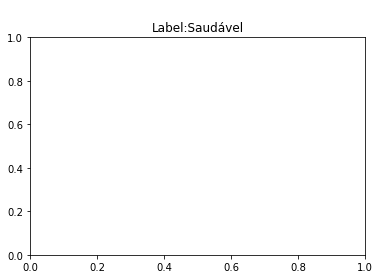

In [72]:
# 2) Extract the features with one of four methods: 'HUMOMENTS'
imgPreProcessamento = extract_features(imagesBase)
print('Extract features method: HUMOMENTS')

# 3) Split data into train & test sets, including shuffle of the data
amostraImgTreino, amostraTreino, amostraImgTeste, amostraTeste = splitTestTrain(imgPreProcessamento, dadosClassificacao)

# 4) Train the models
# print('Begins testing the models...')

results, fPositivo, vPositivo, fNegativo, vNegativo = adaBoost(amostraImgTreino, amostraTreino, amostraImgTeste, amostraTeste)
#print("FP: ",fPositivo, "| VP:",vPositivo, "| FN:",fNegativo, "| VN:",vNegativo)

acuracia = ((vPositivo + vNegativo)/(vPositivo + fPositivo + vNegativo + fNegativo))*100
especificidade = (vNegativo/(vNegativo + fPositivo))*100
sensibilidade = (vPositivo/(vPositivo + fNegativo))*100

# print('The average results for standard machine learning models, with range:', s)
print('adaBoost: {:.2f}%'.format(results))
print('Acurácia: {:.2f}%'.format(acuracia))
print('Especificidade: {:.2f}%'.format(especificidade))
print('Sensibilidade: {:.2f}%'.format(sensibilidade))
print('=============================')
